<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Side_Objective_IPI_female_bimodal_separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Identify medians in bimodal distributions

This notebook follows Side_Objective_IPI_pipeline. We have confirmed that in some female individuals IPI distribution is indeed bimodal. We plan on generating the density plot in those individuals, find the trough in the plot, and separate the bimodal distribution to find the medians in both distributions. 

Bimodal individuals:
- One in petersii
- Two in poweri

In [37]:
import os
import librosa
import time
import seaborn as sns
from librosa import display
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import scipy
import csv
import random
from scipy import fftpack, signal
from scipy.ndimage import gaussian_filter1d
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft
import pandas as pd
from scipy.stats import norm, gaussian_kde

###Female-male Separation Pipeline

In [11]:
def clear_out(lower,upper,data,points_per_freq):
  target_idx_noise_lower = int(points_per_freq * lower)
  target_idx_noise_upper = int(points_per_freq * upper)
  data[: target_idx_noise_lower] = 0
  data[target_idx_noise_upper:] = 0
  
def fourier_transform(samples, sampling_rate):
  #fourier transform on audio file
  yf = rfft(samples)
  xf = rfftfreq(len(samples), 1 / sampling_rate)
  return xf,yf

#smooth the curve
def smooth_curve(randomlist_yf,sigma=40):
  #We get a smoother curve upon increasing the value of sigma.
  y_smoothed = gaussian_filter1d(randomlist_yf, sigma)
  peaks, _  = scipy.signal.find_peaks(y_smoothed)
  troughs, _  = scipy.signal.find_peaks(-y_smoothed)
  return peaks,troughs,y_smoothed

def peak_processing(peaks,randomlist_xf):
  #remove all peaks with xf value below 450, between 700 and 1600, and above 2500
  for i in peaks:
    if((randomlist_xf[i]<450) or
      #((randomlist_xf[i]>700) and (randomlist_xf[i]<1600))or
      (randomlist_xf[i]>2500)):
      peaks = np.delete(peaks,np.argwhere(peaks == i))
  peaks_list = randomlist_xf[peaks]
  return peaks_list

def trough_processing(troughs,randomlist_xf):
  #if the smallest trough that's below 450 is below 350  replace it with 350
  if(randomlist_xf[troughs].min()<350):
    troughs_list = np.where(randomlist_xf[troughs]<350,350,randomlist_xf[troughs])
  else:
    troughs_list = np.append([350], randomlist_xf[troughs], axis = 0)
  return troughs_list

def generate_boundaries(peaks_list,troughs_list):
  #getting the boundaries for the female call
  i = 0
  while(troughs_list[i] < peaks_list[0]):
    i+=1
  upper_bound_0 = troughs_list[i]
  lower_bound_0 = troughs_list[i-1]

  #getting the boundaries for the male call
  while(troughs_list[i] < peaks_list[1]):
    i+=1
  upper_bound_1 = troughs_list[i]
  #the lower bound of the male call: take the 
  #difference between the upper bound and the peak,
  #and use the peak value to subtract the difference
  difference = upper_bound_1 - peaks_list[1]
  lower_bound_1 = peaks_list[1] - difference
  #the lower bound of male call can't go below 1500Hz for
  #Xenopus Laevis or Xenopus Petersii
  if(lower_bound_1 < 1500):
    lower_bound_1 = 1500
  boundary_list = [150,lower_bound_0,upper_bound_0,lower_bound_1,3000]
  return boundary_list

def write_audio(samples,lowerlimit,upperlimit,points_per_freq,file_name,specific_name,sampling_rate=44100):
  yf_special = rfft(samples)
  clear_out(lowerlimit,upperlimit,yf_special,points_per_freq)
  new_sig = irfft(yf_special)
  write(file_name+specific_name,sampling_rate,new_sig)

In [12]:
def separation_for_IPI_calculating(file_path,sampling_rate=44100):
  file_name = os.path.basename(file_path)
  #load audio file
  samples, sampling_rate = librosa.load(file_path,sr=sampling_rate)

  #perform fourier transform on the data
  xf,yf = fourier_transform(samples, sampling_rate)

  #get the number of points per frequency
  points_per_freq = len(xf) / (sampling_rate / 2)

  #rough clean of data for smoothing
  clear_out(150,3000,yf,points_per_freq)

  #sample down audio file to 23274 data points
  randomlist = random.sample(list(range(0,(len(xf)-1))),23274)
  randomlist.sort()
  randomlist_xf = xf[randomlist]
  randomlist_yf = np.abs(yf)[randomlist]

  peaks,troughs,y_smoothed = smooth_curve(randomlist_yf)

  #data processing on the peaks and troughs
  peaks_list = peak_processing(peaks,randomlist_xf)
  troughs_list = trough_processing(troughs,randomlist_xf)

  boundary_list = generate_boundaries(peaks_list,troughs_list)

  #plot the graph
  '''
  plt.figure(figsize=(20,5))
  plt.plot(xf,np.abs(yf),color="grey")
  plt.plot(randomlist_xf,y_smoothed,color="red")
  plt.plot(randomlist_xf[peaks],y_smoothed[peaks],"x")
  plt.plot(randomlist_xf[troughs],y_smoothed[troughs],"o",color="green")
  plt.vlines(boundary_list,-10,3000,colors='black', linestyles='dashed')
  ticks = np.concatenate([np.arange(0, 4000, step=1000),boundary_list])
  ticks.sort()
  plt.xticks(ticks)
  plt.xlim((0,4000))
  plt.show()
  '''
  #obtain female signal
  yf_special = rfft(samples)
  clear_out(boundary_list[1],boundary_list[2],yf_special,points_per_freq)
  female = irfft(yf_special)

  #obtain noise signal
  yf_special = rfft(samples)
  clear_out(boundary_list[0],350,yf_special,points_per_freq)
  noise = irfft(yf_special)

  print('female lower bound: ',boundary_list[1])
  print('female higher bound: ',boundary_list[2])
  return female, noise

###Wave Envelope and Find Peaks

In [13]:
#get statistics on rapping IPI
def get_rapping_IPI_stats(peak_indices_list,x_time):
  IPI = []
  for i in range(0,len(peak_indices_list)-1):
    front = peak_indices_list[i]
    back = peak_indices_list[i+1]
    difference = x_time[back] - x_time[front]
    IPI.append(difference)
  #Assumption: Rapping is categorized by 3 or more consecutive pulses within 1 second.
  i=0
  IPI_processed = []
  while (i < (len(IPI)-2)):
  #while(0):
    if((IPI[i]+IPI[i+1])<1):
      IPI_processed.append(IPI[i])
      IPI_processed.append(IPI[i+1])
      k = 2
      while(1):
        if((IPI[i+k]<0.5)and(i+k <(len(IPI)-1))):
          IPI_processed.append(IPI[i+k])
          k=k+1
        else:
          i = i+k+1
          break
    else:
      i=i+1
  #generate statistics for rapping IPI plot
  std = np.std(IPI_processed)
  mean = np.mean(IPI_processed)
  median = np.median(IPI_processed)

  IPI_processed = [i for i in IPI_processed if (i<median+2*std)]

  std = np.std(IPI_processed)
  mean = np.mean(IPI_processed)
  median = np.median(IPI_processed)
  return IPI_processed, mean, median, std

In [14]:
def IPI_calculation(file_path):
  female, noise = separation_for_IPI_calculating(file_path)
  hilbert_signal = abs(signal.hilbert(female))
  #time vector
  sampling_rate = 44100
  duration = len(hilbert_signal)/sampling_rate
  x_time = np.arange(0,duration,1/sampling_rate)
  threshold = 0.05*np.max(hilbert_signal)
  peaks, _  = scipy.signal.find_peaks(hilbert_signal,height=threshold,distance=0.05*44100)
  plt.figure(figsize=(20,5))
  plt.plot(x_time, hilbert_signal)
  plt.plot(x_time[peaks], hilbert_signal[peaks], 'x')
  #plt.xlim(40*44100, 41*44100)
  plt.show()

  IPI_processed,mean,median,std = get_rapping_IPI_stats(peaks,x_time)
  print("Mean: ", mean,"; Median: ",median, "; STD: ", std)

###Execution Function

In [92]:
def female_bimodal_separation(file_path):
  female, noise = separation_for_IPI_calculating(file_path)
  hilbert_signal = abs(signal.hilbert(female))
  #time vector
  sampling_rate = 44100
  duration = len(hilbert_signal)/sampling_rate
  x_time = np.arange(0,duration,1/sampling_rate)
  threshold = 0.05*np.max(hilbert_signal)
  peaks, _  = scipy.signal.find_peaks(hilbert_signal,height=threshold,distance=0.05*44100)
  '''
  plt.figure(figsize=(20,5))
  plt.plot(x_time, hilbert_signal)
  plt.plot(x_time[peaks], hilbert_signal[peaks], 'x')
  #plt.xlim(40*44100, 41*44100)
  plt.show()
  '''
  IPI_processed,mean,median,std = get_rapping_IPI_stats(peaks,x_time)
  df = pd.DataFrame (IPI_processed, columns = ['IPI_processed'])
  return df

####Poweri execution



#####First Individual Poweri

In [100]:
df = female_bimodal_separation('/content/Poweri_03-AD7ED-AD7F8-220713_1913_8_min.wav')

female lower bound:  474.464339069948
female higher bound:  1256.6624268030125


(0.0, 0.5)

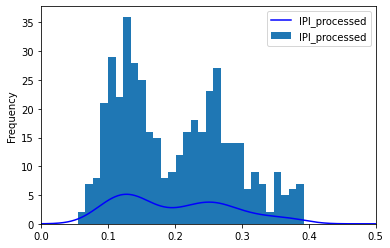

In [101]:
ax = df.plot.kde(color="blue")
df.plot.hist(bins=30,ax=ax)
plt.xlim(0,0.5)

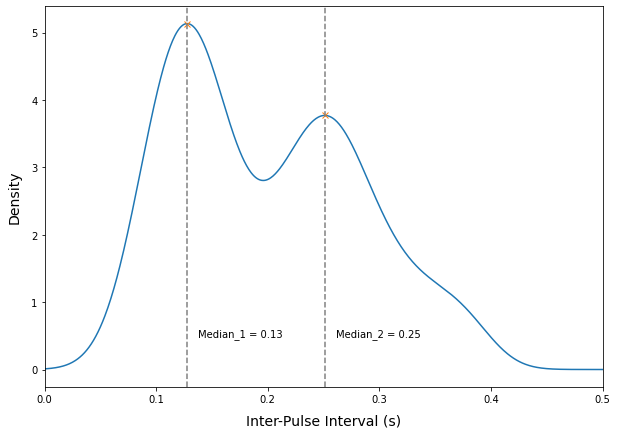

Median 1:  0.12762776381824528
Median 2:  0.25126187411900996


In [116]:
ax = df.plot.kde(color="blue")
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

plt.figure(figsize=(10,7))
plt.plot(x,y)
plt.plot(x[peaks],y[peaks],'x')
plt.xlim(0,0.5)
plt.xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
plt.ylabel('Density',fontsize=14,labelpad=10)

#print medians
Median_1 = x[peaks][0]
Median_2 = x[peaks][1]

plt.text(Median_1+0.01,0.5,s="Median_1 = "+format(Median_1, ".2f"))
plt.text(Median_2+0.01,0.5,s="Median_2 = "+format(Median_2, ".2f"))

plt.axvline(Median_1,linestyle="dashed",color="grey")
plt.axvline(Median_2,linestyle="dashed",color="grey")

plt.show()

print('Median 1: ', Median_1)
print('Median 2: ', Median_2)

#####Second Individual Poweri

female lower bound:  365.9178988037821
female higher bound:  841.6052444777883


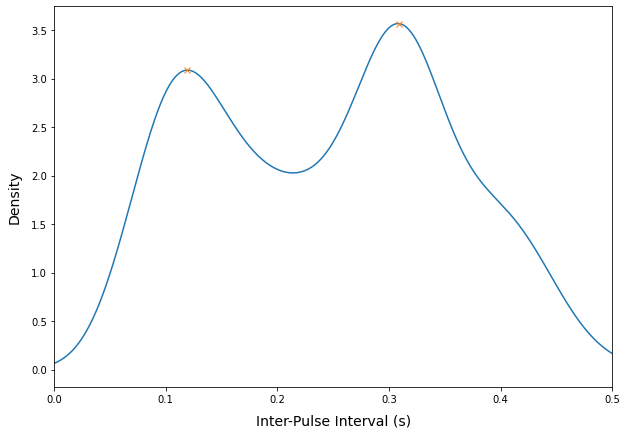

Median 1:  0.11943746467556099
Median 2:  0.30854094457269365


In [97]:
#second individual
df = female_bimodal_separation('/content/Poweri_02-AD826-AD80A-220712_0006_8_min.wav')
ax = df.plot.kde(color="blue")
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

plt.figure(figsize=(10,7))
plt.plot(x,y)
plt.plot(x[peaks],y[peaks],'x')
plt.xlim(0,0.5)
plt.xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
plt.ylabel('Density',fontsize=14,labelpad=10)
plt.show()

#print medians
Median_1 = x[peaks][0]
Median_2 = x[peaks][1]
print('Median 1: ', Median_1)
print('Median 2: ', Median_2)

####Petersii execution